<br>

# Molecular Dynamics and Ab Initio Simulations : Developing a Predictive Model for Molecular Energy Configurations

## Table of contents:

* [First view on data](#first-view-on-data)
    * [MO2S4 dataset](#mo2s4-dataset)
    * [Zundel dataset](#zundel-dataset)
* [Data Preprocessing](#data-preprocessing)
    * [Naive and linear regression model](#naive-and-linear-regression-model)
        * [Naive model](#naive-model)
        * [Linear regression model](#linear-regression-model)
        * [Again with Zundel Ions](#again-with-zundel-ions)
    * [Describing the data with other representations](#describing-the-data-with-other-representations)
        * [Coulomb matrix](#coulomb-matrix)
        * [Ewald sum matrix](#ewald-sum-matrix)


This project involves utilizing results from ab initio molecular dynamics simulations to develop a model capable of predicting the energy associated with specific molecular configurations. It leverages two datasets: the first encompasses simulations on the dynamics of the Zundel ion (H2O-H-H2O), while the second focuses on a Mo2S4 aggregate. Each dataset contains about 10,000 atomic configurations and their corresponding potential energies, providing a comprehensive basis for accurate energy prediction in molecular systems.

<br>

<br>

## First view on data <a class="anchor" id="first-view-on-data"></a>

### MO2S4 dataset <a class="anchor" id="mo2s4-dataset"></a>

First, let's try to render a configuration on a 3D plot. We will first look into the MO2S4 dataset by plotting the first and last configurations.

<br>

In [114]:
%matplotlib inline

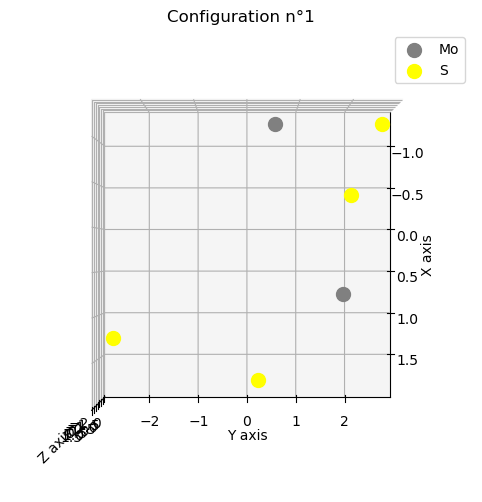

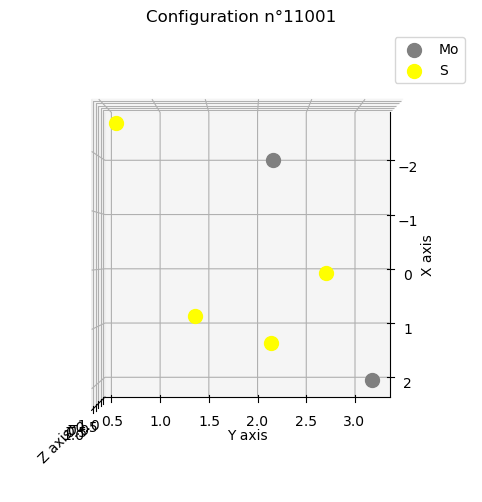

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MO2S4_file_path = 'data/MO2S4/TRAJEC_short.xyz'

# Re-reading the file to confirm its structure
with open(MO2S4_file_path, 'r') as file:
    MO2S4_file_content = file.readlines()

# Parsing the first configuration from the file
# Skipping the first two lines (number of atoms and comment) and taking the next six lines for the first configuration

def plot_configuration_MO2S4(first_line, last_line):

    configuration = MO2S4_file_content[first_line:last_line]

    # Extracting atom types and their positions
    atom_types = []
    positions = []

    for line in configuration:
        parts = line.split()
        atom_types.append(parts[0])  # Atom type (Mo or S)
        positions.append([float(parts[1]), float(parts[2]), float(parts[3])])  # x, y, z coordinates

    positions = np.array(positions)

    # Creating a 3D scatter plot using 'o' markers to represent atoms
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plotting each atom with 'o' marker
    for i, atom in enumerate(atom_types):
        x, y, z = positions[i]
        color = 'gray' if atom == 'Mo' else 'yellow'  # Gray for Mo, Yellow for S
        ax.scatter(x, y, z, c=color, marker='o', s=100)  # Adjust size as needed

    # Adding labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Visualization of Atomic Configuration with Scatter Plot')

    # Add legend
    ax.scatter([], [], [], c='gray', marker='o', s=100, label='Mo')
    ax.scatter([], [], [], c='yellow', marker='o', s=100, label='S')
    ax.legend()
    
    # Set the view to XY plane
    ax.view_init(elev=90, azim=0)

    # Add a title

    plt.title('Configuration n°' + str(last_line//8))

    plt.show()

plot_configuration_MO2S4(2,8)
plot_configuration_MO2S4(88002,88008)

<br>

We can check these configurations with an image from Jmol:

<br>

#### First configuration :

![image](img/first_config_MO2S4.png)
<br>

#### Last configuration :

![image](img/last_config_MO2S4.png)

<br>

We can see the plotting are correct (even tho there is a slight difference in the position of the atoms, but it is due to the fact that the Jmol image is not in the exact same orientation as the plotting).

<br>


We notice that the configurations are quite different.

Properties of ``TRAJEC_short.xyz`` :
- 11,001 configurations (88,008 lines/8 lines per configuration).
- No units for positions, but it can be assumed that they are in Angstroms ($\AA = 10^-{10}m$).

It is quickly noticed that there are 11,001 lines in the ``energies.out`` file, and the same in the ``potential-energy`` file. It seems that the values in ``potential-energy.txt`` correspond to those in ``energies.out``. We can then verify this:

<br>

In [116]:
MO2S4_energies_out = pd.read_csv("data/MO2S4/energies.out", delim_whitespace=True)
MO2S4_energies_out.head()

,step,none,temp,potential_energy,none.1,none.2,none.3,none.4
0,1,0.00000000,1278.492,-176.957259,-176.893668,0.0,0.000062,1.31
1,5,0.00000000,8620.471,-176.992785,-175.702624,0.0,0.036543,1.56
2,10,0.00000000,954.638,-176.996302,-175.624659,0.0,0.095147,0.84
3,15,0.00000000,319.990,-176.997355,-175.621132,0.0,0.121177,1.05
4,20,0.00000000,273.078,-177.004502,-175.619745,0.0,0.137373,1.32


In [117]:
MO2S4_potential_energy = pd.read_csv('data/MO2S4/potential-energy.txt', delim_whitespace=True, header=None)
MO2S4_potential_energy.columns = ['potential_energy']
MO2S4_potential_energy.head()

,potential_energy
0,-176.957259
1,-176.992785
2,-176.996302
3,-176.997355
4,-177.004502


In [118]:
# On teste si les deux colonnes sont égales
print(MO2S4_energies_out['potential_energy'].equals(MO2S4_potential_energy['potential_energy']))

True


<br>


The two columns quickly lead us to assume that the ``energies.out`` file represents the energies of the 11,001 configurations in the ``TRAJEC_short.xyz`` file. We can then simply use the energies.out file to train our model.

<br>

### Zundel dataset <a class="anchor" id="zundel-dataset"></a>

<br>

This dataset is composed of only two files, ``new_energies_sparse.out`` and ``new_positions_sparse.xyz``. We can directly see that these two files are, resp., the energy table we saw on ``energies.out`` and the ``TRAJEC_short.xyz``. Let's import them and look the same way as the MO2S4.

<br>


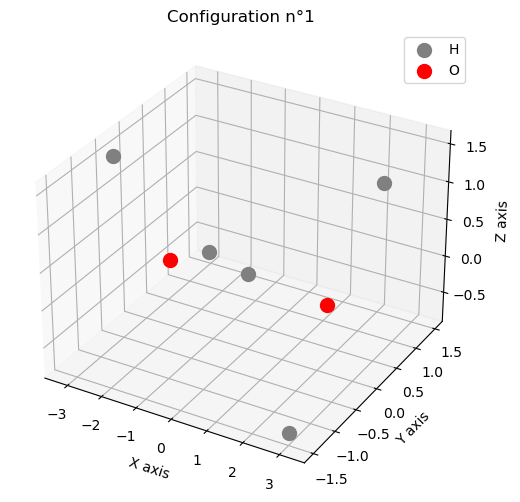

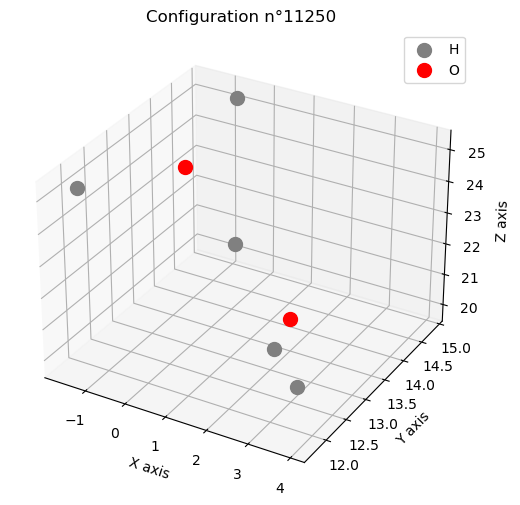

In [119]:
zundel_file_path = 'data/zundel_ions/new_positions_sparse.xyz'

# Re-reading the file to confirm its structure
with open(zundel_file_path, 'r') as file:
    zundel_file_content = file.readlines()

# Parsing the first configuration from the file
# Skipping the first two lines (number of atoms and comment) and taking the next six lines for the first configuration

def plot_configuration_zundel(first_line, last_line):

    configuration = zundel_file_content[first_line:last_line]

    # Extracting atom types and their positions
    atom_types = []
    positions = []

    for line in configuration:
        parts = line.split()
        atom_types.append(parts[0])  # Atom type (O or H)
        positions.append([float(parts[1]), float(parts[2]), float(parts[3])])  # x, y, z coordinates

    positions = np.array(positions)

    # Creating a 3D scatter plot using 'o' markers to represent atoms
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plotting each atom with 'o' marker
    for i, atom in enumerate(atom_types):
        x, y, z = positions[i]
        color = 'red' if atom == 'O' else 'gray'  # Gray for H, Red for O
        ax.scatter(x, y, z, c=color, marker='o', s=100)  # Adjust size as needed

    # Adding labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Visualization of Atomic Configuration with Scatter Plot')

    # Add legend
    ax.scatter([], [], [], c='gray', marker='o', s=100, label='H')
    ax.scatter([], [], [], c='red', marker='o', s=100, label='O')
    ax.legend()

    # Add a title

    plt.title('Configuration n°' + str(last_line//8))

    plt.show()

plot_configuration_zundel(2,9)
plot_configuration_zundel(89993,90000)

<br>

Again, we can check these configurations with an image from Jmol:

<br>

#### First configuration :

![image](img/first_config_zundel.png)
<br>

#### Last configuration :

![image](img/last_config_zundel.png)

<br>

We see that ...

<br>

Now let's check the table of energies:

In [120]:
# uniquement prendre la 5ème colonne
zundel_potential_energy = pd.read_csv('data/zundel_ions/new_energies_sparse.out', delim_whitespace=True, header=None, usecols=[4], names=['potential_energy'])
zundel_potential_energy.head()
zundel_potential_energy.describe()

,potential_energy
count,10000.000000
mean,0.002538
std,0.000910
min,0.000096
25%,0.001879
50%,0.002431
75%,0.003082
max,0.007210


## Data Preprocessing <a class="anchor" id="data-preprocessing"></a>

<br>

The goal here is to describe the data and to prepare it for the model. Indeed, we will try to directly use the data as it is, without any preprocessing and use a naive model, and then we will try to preprocess it to see if it improves the model.

<br>

### Naive and linear regression model <a class="anchor" id="naive-and-linear-regression-model"></a>

<br>

We will first try to use the data as it is, without any preprocessing. By this, I mean we will use the coordinates of the atoms as features and the potential energy as the target. Then, we will use the mean of the potential energy as a naive model to predict the potential energy of a configuration and check the score of this model.

In [121]:
# data : MO2S4_file_content (6 lignes par configuration, séparés par 2 lignes, commence à ligne 2)
# Les 6 lignes sont : type d'atome, x, y, z
# on va d'abord récupérer dans l'ordre les positions des atomes dans chaque configuration et les placer dans une liste à 18 dimensions (6*3 dimensions par atome)

def get_liste_configurations_MO2S4():
    liste_configurations = []
    
    for i in range(2, len(MO2S4_file_content), 8):
        configuration = []
        for j in range(6):
            configuration.append(MO2S4_file_content[i+j].split()[1:])
        liste_configurations.append(configuration)
    
    liste_configurations = np.array(liste_configurations, dtype=float)
    
    return liste_configurations

liste_configurations = get_liste_configurations_MO2S4()

print(f" Nombres de configurations : {len(liste_configurations)}"
      f"\n Dimensions de la première configuration : {liste_configurations[0].shape}"
      f"\n Première configuration : \n {liste_configurations[0]}"
      f"\n Moyenne des positions des configurations : \n {np.mean(liste_configurations, axis=0)}"
      f"\n Ecart-type des positions des configurations : \n {np.std(liste_configurations, axis=0)}"
      f"\n Minimum des positions des configurations : \n {np.min(liste_configurations, axis=0)}"
      f"\n Maximum des positions des configurations : \n {np.max(liste_configurations, axis=0)}")


 Nombres de configurations : 11001
 Dimensions de la première configuration : (6, 3)
 Première configuration : 
 [[ 0.746648  1.869656  0.279349]
 [-1.188737  0.558299 -0.089274]
 [ 1.795806  0.234278 -1.878226]
 [-1.139974  2.551034  1.381834]
 [-0.410638  2.128456 -1.909369]
 [ 1.230796 -2.537868  1.275581]]
 Moyenne des positions des configurations : 
 [[0.70660374 2.24968146 0.40045112]
 [0.5333103  1.04449557 0.45250144]
 [0.41124667 1.94025897 0.01663025]
 [0.32677503 2.32664991 0.11183954]
 [0.22970309 1.21658537 0.13250167]
 [1.31070329 1.08543397 0.79624568]]
 Ecart-type des positions des configurations : 
 [[1.00512999 0.91284739 1.2601428 ]
 [1.15492425 0.70500757 0.9058091 ]
 [0.97871082 1.52298532 1.31281585]
 [0.88091546 1.23522166 0.87012479]
 [1.47769804 0.72970001 1.14937565]
 [0.86425788 1.68849477 1.04346837]]
 Minimum des positions des configurations : 
 [[-1.857595  0.289364 -2.367561]
 [-1.875278 -0.750295 -1.389803]
 [-1.824819 -1.258395 -2.064855]
 [-1.342688 -0

In [122]:
# On peut maintenant récupérer les énergies potentielles dans le fichier potential-energy.txt et les placer dans un array numpy

def get_energies_MO2S4():
    energies = []
    
    for i in range(len(MO2S4_potential_energy)):
        energies.append(MO2S4_potential_energy['potential_energy'][i])
    
    energies = np.array(energies, dtype=float)
    
    return energies

energies = get_energies_MO2S4()

print(f" Nombres d'énergies : {len(energies)}"
      f"\n Première énergie : {energies[0]}"
      f"\n Dernière énergie : {energies[-1]}"
      f"\n Moyenne des énergies : {np.mean(energies)}"
      f"\n Ecart-type des énergies : {np.std(energies)}"
      f"\n Minimum des énergies : {np.min(energies)}, indice : {np.argmin(energies)}"
      f"\n Maximum des énergies : {np.max(energies)}, indice : {np.argmax(energies)}")

 Nombres d'énergies : 11001
 Première énergie : -176.9572587946
 Dernière énergie : -176.2992603329
 Moyenne des énergies : -174.78168354970256
 Ecart-type des énergies : 32.3810590146537
 Minimum des énergies : -177.2277536385, indice : 537
 Maximum des énergies : 633.4860704294, indice : 10868


<br>

#### Naive model <a class="anchor" id="naive-model"></a>

Now, we can create a naive model that predicts the mean of the potential energies using the atom positions as features and the potential energies as the target. The scoring method used will be the Mean Squared Error (MSE).

<br>

In [128]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# On peut maintenant créer un modèle naïf qui va prédire la moyenne des énergies potentielles

X = liste_configurations
y = energies

y_pred = np.full(len(energies), np.mean(energies))

score = mean_squared_error(energies, y_pred)

#RMSE
print(f" RMSE du modèle naïf : {np.sqrt(score)}")

#MAE

print(f" MAE du modèle naïf : {np.mean(np.abs(y_pred - energies))}")

 RMSE du modèle naïf : 32.3810590146537
 MAE du modèle naïf : 3.5038519711548513


<br>

We obtain an MSE of 1048, which is a high score for energies on the order of $10^2$. Therefore, we can conclude that the naive model is not suitable for this problem.

We also easily notice that the RMSE is equal to the standard deviation of the energies, which makes sense since the naive model predicts the mean of the energies, and the standard deviation is the measure of energy dispersion around the mean.

<br>

#### Linear regression model <a class="anchor" id="linear-regression-model"></a>

We can now try a slightly more complex model, using the atom positions as features and the potential energies as the target. We will use a linear regression model and split the data into a training set and a test set. Then, we will calculate the MSE and RMSE of this model.

<br>

In [129]:
from sklearn.model_selection import train_test_split

# On sépare les données en un jeu d'entraînement et un jeu de test

print(X.shape)
flattened_X = X.reshape(11001, 18)
print(flattened_X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(flattened_X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f" Dimensions du jeu d'entraînement : {X_train.shape}"
      f"\n Dimensions du jeu de test : {X_test.shape}"
      f"\n Dimensions du jeu d'entraînement : {y_train.shape}"
      f"\n Dimensions du jeu de test : {y_test.shape}")   


(11001, 6, 3)
(11001, 18)
(11001,)
 Dimensions du jeu d'entraînement : (8800, 18)
 Dimensions du jeu de test : (2201, 18)
 Dimensions du jeu d'entraînement : (8800,)
 Dimensions du jeu de test : (2201,)


 RMSE du modèle naïf : 28.659910056154853
 MAE du modèle naïf : 3.8799244281950647
 Pearsons correlation: 0.103


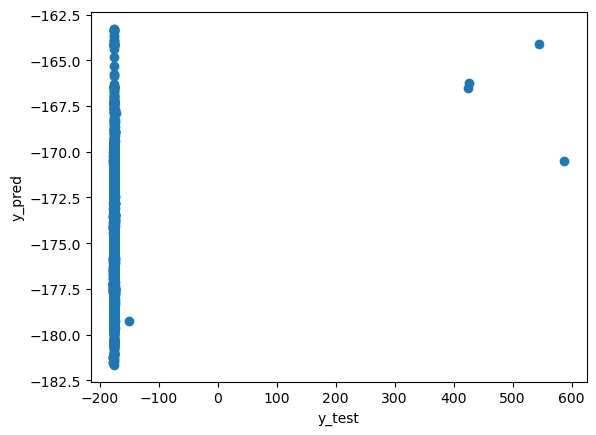

In [130]:
from sklearn.linear_model import LinearRegression

# On crée le modèle de régression linéaire

linear_regression = LinearRegression()

# On entraîne le modèle

linear_regression.fit(X_train, y_train)

# On prédit les énergies potentielles du jeu de test

y_pred = linear_regression.predict(X_test)

# On calcule le MSE et le RMSE

score = mean_squared_error(y_test, y_pred)


#RMSE
print(f" RMSE du modèle naïf : {np.sqrt(score)}")

#MAE

print(f" MAE du modèle naïf : {np.mean(np.abs(y_pred - y_test))}")

# get the Pearson correlation coefficient

from scipy.stats import pearsonr

corr, _ = pearsonr(y_test, y_pred)
print(' Pearsons correlation: %.3f' % corr)

# plot y_test vs y_pred

plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

<br>

We notice that we have reduced the MSE, but not by much. Therefore, we can deduce that the linear regression model is not suitable for this problem. The question then arises whether the issue lies with the model or the data. We will attempt to improve the data to see if the model performs better.

It's also worth noting that in this case, we do not differentiate between atoms by their type; we only consider the positions of the atoms. However, since the atom indices remain the same in the ``TRAJEC_short.xyz`` file, we can assume that their types are determined accordingly.

<br>

#### Again with Zundel Ions <a class="anchor" id="again-with-zundel-ions"></a>

We will repeat the same process for the Zundel ions.


In [133]:
X_train, X_test, y_train, y_test = train_test_split(flattened_X, y, test_size=0.2, random_state=42)

# Création du modèle
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense

cb_sauvegarde = ModelCheckpoint(filepath='save/classic_mo2s4.keras', save_best_only=True)

model = Sequential()

model.add(Dense(units=64, activation='relu', input_shape=(18,)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=18, activation='relu'))
model.add(Dense(units=18, activation='relu'))

model.add(Dense(units=1, activation='linear'))

model.summary()

C:\Users\lucas\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_99 (Dense)                │ (None, 64)                │      1,216 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_100 (Dense)               │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_101 (Dense)               │ (None, 18)                │        594 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_102 (Dense)               │ (None, 18)                │        342 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_103 (Dense)               │ (None, 1)                 │         19 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 4,251 (16.61 KB)

 Trainable params: 4,251 (16.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# let's train the model

from keras.optimizers import Adam

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001,use_ema=True), metrics=['mse', 'mae'])

history = model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=1, validation_split=0.2,callbacks=[cb_sauvegarde])

# evaluate the model

scores = model.evaluate(X_test, y_test)

# resulsts and graph of history for RMSE

print(f"Score du modèle: {scores}")

# pearson correlation

y_pred = model.predict(X_test)

corr, _ = pearsonr(y_test, y_pred)

print(' Pearsons correlation: %.3f' % corr)

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
# data : zundel_file_content (7 lignes par configuration, séparés par 2 lignes, commence à ligne 3)

def get_liste_configurations_zundel():
    liste_configurations = []
    
    for i in range(2, len(zundel_file_content), 9):
        configuration = []
        for j in range(7):
            configuration.append(zundel_file_content[i+j].split()[1:])
        liste_configurations.append(configuration)
    
    liste_configurations = np.array(liste_configurations, dtype=float)
    
    return liste_configurations

liste_configurations = get_liste_configurations_zundel()

print(liste_configurations.shape)

print(f" Nombres de configurations : {len(liste_configurations)}"
      f"\n Dimensions de la première configuration : {liste_configurations[0].shape}"
      f"\n Première configuration : \n {liste_configurations[0]}"
      f"\n Moyenne des positions des configurations : \n {np.mean(liste_configurations, axis=0)}"
      f"\n Ecart-type des positions des configurations : \n {np.std(liste_configurations, axis=0)}"
      f"\n Minimum des positions des configurations : \n {np.min(liste_configurations, axis=0)}"
      f"\n Maximum des positions des configurations : \n {np.max(liste_configurations, axis=0)}")


In [ ]:
# On peut maintenant récupérer les énergies

def get_energies_zundel():
    energies = []
    
    for i in range(len(zundel_potential_energy)):
        energies.append(zundel_potential_energy['potential_energy'][i])
    
    energies = np.array(energies, dtype=float)
    
    return energies

energies = get_energies_zundel()

print(f" Nombres d'énergies : {len(energies)}"
      f"\n Première énergie : {energies[0]}"
      f"\n Dernière énergie : {energies[-1]}"
      f"\n Moyenne des énergies : {np.mean(energies)}"
      f"\n Ecart-type des énergies : {np.std(energies)}"
      f"\n Minimum des énergies : {np.min(energies)}, indice : {np.argmin(energies)}"
      f"\n Maximum des énergies : {np.max(energies)}, indice : {np.argmax(energies)}")


In [ ]:
# On peut maintenant créer un modèle naïf qui va prédire la moyenne des énergies potentielles

X = liste_configurations
y = energies

y_pred = np.full(len(energies), np.mean(energies))

score = mean_squared_error(energies, y_pred)

# RMSE
print(f" RMSE du modèle naïf : {np.sqrt(score)}")
# MAE
print(f" MAE du modèle naïf : {np.mean(np.abs(y_pred - energies))}")

In [ ]:
from sklearn.model_selection import train_test_split

# On sépare les données en un jeu d'entraînement et un jeu de test

print(X.shape)
flattened_X = X.reshape(10000, 21)
print(flattened_X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(flattened_X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f" Dimensions du jeu d'entraînement : {X_train.shape}"
      f"\n Dimensions du jeu de test : {X_test.shape}"
      f"\n Dimensions du jeu d'entraînement : {y_train.shape}"
      f"\n Dimensions du jeu de test : {y_test.shape}")


In [ ]:
from sklearn.linear_model import LinearRegression

# On crée le modèle de régression linéaire

linear_regression = LinearRegression()

# On entraîne le modèle

linear_regression.fit(X_train, y_train)

# On prédit les énergies potentielles du jeu de test

y_pred = linear_regression.predict(X_test)

# On calcule le MSE et le RMSE

score = mean_squared_error(y_test, y_pred)

#RMSE
print(f" RMSE du modèle naïf : {np.sqrt(score)}")

#MAE

print(f" MAE du modèle naïf : {np.mean(np.abs(y_pred - y_test))}")

# get the Pearson correlation coefficient

from scipy.stats import pearsonr

corr, _ = pearsonr(y_test, y_pred)
print(' Pearsons correlation: %.3f' % corr)

# plot y_test vs y_pred

plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

Here, we can observe that our linear model performs even worse than our naive model: $RMSE_{linear} = 9.15 \cdot 10^{-4}$ and $RMSE_{naive} = 9.09 \cdot 10^{-4}$.

However, the Persons correlation coefficient between predicted data and real data is very low.

The goal is to modify the data in order to be able to analyze it afterward.

### Describing the data with other representations <a class="anchor" id="describing-the-data-with-other-representations"></a>

<br>

BLabla

<br>

We will use the [Dscribe](https://singroup.github.io/dscribe/latest/) package to describe the data with other representations.

<br>


In [ ]:
# Not working with this version of numpy, see the generate_txt.ipynb file
"""
from dscribe.descriptors import CoulombMatrix
from ase.io import read

def get_atoms_from_xyz(xyz_file_path):
    # Read the atomic coordinates from the XYZ file
    atoms = read(xyz_file_path, format='xyz', index=':')
    return atoms

MO2S4_atoms = get_atoms_from_xyz('data/MO2S4/TRAJEC_short.xyz')
"""
print("nope")


#### Coulomb matrix <a class="anchor" id="coulomb-matrix"></a>

<br>

The Coulomb matrix encodes the atomic species and interatomic distances of a finite system in a pair-wise, two-body matrix inspired by the form of the Coulomb potential. The elements of this matrix are given by :

$$ M_{ij} = \begin{cases} \frac{1}{2} Z_i^{2.4} & \text{if } i = j \\ \frac{Z_i Z_j}{|R_i - R_j|} & \text{if } i \neq j \end{cases} $$

where $Z_i$ is the atomic number of atom $i$ and $|R_i - R_j|$ is the Euclidian distance between atoms i and j.


In [ ]:
"""
def get_coulomb_matrix(atoms):
    # Create a Coulomb matrix
    cm = CoulombMatrix(n_atoms_max=len(MO2S4_atoms[0]), permutation="sorted_l2")
    coulomb_matrix = cm.create(atoms)
    return coulomb_matrix

coulomb_matrix = get_coulomb_matrix(MO2S4_atoms[0])
coulomb_matrix_reshaped = coulomb_matrix.reshape((len(MO2S4_atoms[0]),len(MO2S4_atoms[0])))
# Print the Coulomb matrix on a heatmap with values inside the cells
plt.imshow(coulomb_matrix_reshaped, cmap="hot", interpolation="nearest")
plt.colorbar()

# Add a title
plt.title(f"Coulomb matrix for {MO2S4_atoms[0].get_chemical_formula()}")
plt.show()
"""
print("nope")

We indeed succeed to form a matrix with the atomic species and interatomic distances of a finite system. I calculated the first two values of the matrix and they are correct.

<br>

#### Many-body tensor representation <a class="anchor" id="many-body-tensor-representation"></a>

<br>

Another type of representation is the many-body tensor representation (MBTR). It is a generalization of the Coulomb matrix, which is a special case of the many-body tensor representation.

In [ ]:
from dscribe.descriptors import MBTR

#TODO

#### SOAP <a class="anchor" id="soap"></a>

<br>

The Smooth Overlap of Atomic Positions (SOAP) is a local representation that can be used to describe the local environment of atoms in a system. It is based on the idea that the local environment around an atom can be expressed as a sum of spherical harmonics around that atom. The SOAP descriptor is a histogram of the spherical harmonics coefficients.

In [ ]:
from dscribe.descriptors import SOAP

#TODO

<br>

### Analysis with the Coulomb matrix <a class="anchor" id="analysis-with-the-coulomb-matrix"></a>

<br>

We will now try to use the Coulomb matrix to describe the data and see if it improves the model.

<br>

In [136]:
import numpy as np

X = np.genfromtxt('data/txt/MO2S4.txt')
print(f"X shape : {X.shape}")

y = get_energies_MO2S4()
print(f"y shape : {y.shape}")

X shape : (11001, 36)
y shape : (11001,)


In [137]:
# use of StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f" Dimensions du jeu d'entraînement : {X_train.shape}"
      f"\n Dimensions du jeu de test : {X_test.shape}"
      f"\n Dimensions du jeu d'entraînement : {y_train.shape}"
      f"\n Dimensions du jeu de test : {y_test.shape}")

 Dimensions du jeu d'entraînement : (8800, 36)
 Dimensions du jeu de test : (2201, 36)
 Dimensions du jeu d'entraînement : (8800,)
 Dimensions du jeu de test : (2201,)


In [138]:
# On crée le modèle de régression linéaire

linear_regression = LinearRegression()

# On entraîne le modèle

linear_regression.fit(X_train, y_train)

# On prédit les énergies potentielles du jeu de test

y_pred = linear_regression.predict(X_test)

# On calcule le MSE et le RMSE

score = mean_squared_error(y_test, y_pred)

#RMSE

print(f" RMSE du modèle naïf : {np.sqrt(score)}")

#MAE

print(f" MAE du modèle naïf : {np.mean(np.abs(y_pred - y_test))}")

corr, _ = pearsonr(y_test, y_pred)
print(' Pearsons correlation: %.3f' % corr)

 RMSE du modèle naïf : 28.75965688348162
 MAE du modèle naïf : 3.444786544031547
 Pearsons correlation: 0.062


In [139]:
# Création du modèle
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense

cb_sauvegarde = ModelCheckpoint(filepath='save/coulomb_mo2s4_SGD.keras', save_best_only=True)

model = Sequential()

model.add(Dense(units=64, activation='relu', input_shape=(36,)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=18, activation='relu'))
model.add(Dense(units=18, activation='relu'))

model.add(Dense(units=1, activation='linear'))

model.summary()

C:\Users\lucas\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense_109 (Dense)               │ (None, 64)                │      2,368 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_110 (Dense)               │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_111 (Dense)               │ (None, 18)                │        594 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_112 (Dense)               │ (None, 18)                │        342 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_113 (Dense)               │ (None, 1)                 │         19 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 5,403 (21.11 KB)

 Trainable params: 5,403 (21.11 KB)

 Non-trainable params: 0 (0.00 B)

In [146]:
# let's train the model

from keras.optimizers import Adam

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001,use_ema=True), metrics=['mse', 'mae'])

history = model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=1, validation_split=0.2,callbacks=[cb_sauvegarde])

# evaluate the model

scores = model.evaluate(X_test, y_test)

Epoch 1/1000
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 375.4683 - mae: 5.5025 - mean_absolute_percentage_error: 2.9776 - mse: 375.4683 - val_loss: 1724.4568 - val_mae: 7.1052 - val_mean_absolute_percentage_error: 3.2762 - val_mse: 1724.4568
Epoch 2/1000
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 362.4609 - mae: 4.9401 - mean_absolute_percentage_error: 2.6310 - mse: 362.4609 - val_loss: 1728.3805 - val_mae: 7.4010 - val_mean_absolute_percentage_error: 3.4367 - val_mse: 1728.3805
Epoch 3/1000
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 354.9114 - mae: 5.2452 - mean_absolute_percentage_error: 2.8014 - mse: 354.9114 - val_loss: 1769.1084 - val_mae: 9.1043 - val_mean_absolute_percentage_error: 4.4084 - val_mse: 1769.1084
Epoch 4/1000
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 463.0486 - mae: 5.4683 - mean_absolute_percentage_error: 2.8883 - mse: 463.0486 - val_loss: 1759.3593 - val_mae: 8.1803 - val_mean_absolute_percentage_error: 3.8730 - val_mse: 1759.3593
Epoch 5/

KeyboardInterrupt: 

Score du modèle: [816.1104736328125, 3.344068765640259, 816.1104736328125]
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
 Pearsons correlation: 0.330


C:\Users\lucas\AppData\Local\Temp\ipykernel_2704\2583894907.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(' Pearsons correlation: %.3f' % corr)


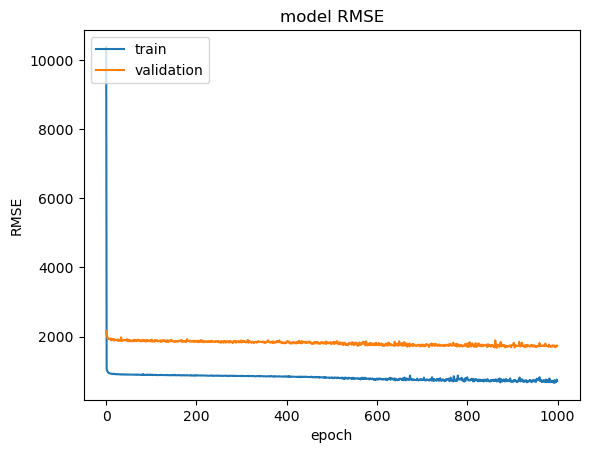

In [147]:


# resulsts and graph of history for RMSE

print(f"Score du modèle: {scores}")

# pearson correlation

y_pred = model.predict(X_test)

corr, _ = pearsonr(y_test, y_pred)

print(' Pearsons correlation: %.3f' % corr)

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
